In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.preprocessing import LabelEncoder
import imblearn
from imblearn.over_sampling import SMOTE
import nltk
import re
import gensim
import string
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from gensim.utils import simple_preprocess
from sklearn.model_selection import train_test_split
from  sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from scipy import stats
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop,Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D,Input
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

In [2]:
from sklearn.model_selection import StratifiedKFold
from transformers import AutoTokenizer,TFBertModel
import tensorflow as tf
from tensorflow.keras.optimizers.schedules import LearningRateSchedule
from sklearn.metrics import accuracy_score,roc_auc_score

In [3]:
df_train = pd.read_csv('train_nlp.csv')
df_test  = pd.read_csv('test_nlp.csv')

In [4]:
df_train.shape,df_test.shape

((7613, 5), (3263, 4))

In [5]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [56]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
dtypes: int64(1), object(3)
memory usage: 238.0+ KB


In [6]:
df_train.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [7]:
df_test.isna().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

In [8]:
#data cleaning

In [9]:
def remove_char(line):
    regex = re.compile(r'https?://\S+|www\.\S+')
    line = re.sub('\s+', ' ', line)
    line = re.sub("\'", "", line)
    line = regex.sub(r'', line)
    line = re.sub('\S*@\S*\s?', '', line)    
    return line

In [10]:
t1 = []
train_list = df_train['text'].values.tolist()
for i in range(len(train_list)):
    t1.append(remove_char(train_list[i]))
t1

['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all',
 'Forest fire near La Ronge Sask. Canada',
 'All residents asked to shelter in place are being notified by officers. No other evacuation or shelter in place orders are expected',
 '13,000 people receive #wildfires evacuation orders in California ',
 'Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school ',
 '#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires',
 '#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas',
 'Im on top of the hill and I can see a fire in the woods...',
 'Theres an emergency evacuation happening now in the building across the street',
 'Im afraid that the tornado is coming to our area...',
 'Three people died from the heat wave so far',
 'Haha South Tampa is getting flooded hah- WAIT A SECOND I LIVE IN SOUTH TAMPA WHAT AM I GONNA DO WHAT AM I GONNA DO FV

In [11]:
t2 = []
test_list = df_test['text'].values.tolist()
for i in range(len(test_list)):
    t2.append(remove_char(test_list[i]))
t2

['Just happened a terrible car crash',
 'Heard about #earthquake is different cities, stay safe everyone.',
 'there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all',
 'Apocalypse lighting. #Spokane #wildfires',
 'Typhoon Soudelor kills 28 in China and Taiwan',
 'Were shaking...Its an earthquake',
 'Theyd probably still show more life than Arsenal did yesterday, eh? EH?',
 'Hey! How are you?',
 'What a nice hat?',
 'Fuck off!',
 'No I dont like cold!',
 'NOOOOOOOOO! Dont do that!',
 'No dont tell me that!',
 'What if?!',
 'Awesome!',
 'Birmingham Wholesale Market is ablaze BBC News - Fire breaks out at Birminghams Wholesale Market ',
 'will you wear shorts for race ablaze ?',
 '#PreviouslyOnDoyinTv: Toke Makinwa\x89Ûªs marriage crisis sets Nigerian Twitter ablaze... ',
 'Check these out:     #nsfw',
 'PSA: I\x89Ûªm splitting my personalities. ?? techies follow ?? Burners follow ',
 'beware world ablaze sierra leone &amp; guap.',
 'Burning Man A

In [12]:
def tokenize(lines):
    for i in lines:
        yield(gensim.utils.simple_preprocess(str(i), deacc=True))

In [13]:
train_tokens = list(tokenize(t1))

In [14]:
test_tokens = list(tokenize(t2))
test_tokens

[['just', 'happened', 'terrible', 'car', 'crash'],
 ['heard',
  'about',
  'earthquake',
  'is',
  'different',
  'cities',
  'stay',
  'safe',
  'everyone'],
 ['there',
  'is',
  'forest',
  'fire',
  'at',
  'spot',
  'pond',
  'geese',
  'are',
  'fleeing',
  'across',
  'the',
  'street',
  'cannot',
  'save',
  'them',
  'all'],
 ['apocalypse', 'lighting', 'spokane', 'wildfires'],
 ['typhoon', 'soudelor', 'kills', 'in', 'china', 'and', 'taiwan'],
 ['were', 'shaking', 'its', 'an', 'earthquake'],
 ['theyd',
  'probably',
  'still',
  'show',
  'more',
  'life',
  'than',
  'arsenal',
  'did',
  'yesterday',
  'eh',
  'eh'],
 ['hey', 'how', 'are', 'you'],
 ['what', 'nice', 'hat'],
 ['fuck', 'off'],
 ['no', 'dont', 'like', 'cold'],
 ['nooooooooo', 'dont', 'do', 'that'],
 ['no', 'dont', 'tell', 'me', 'that'],
 ['what', 'if'],
 ['awesome'],
 ['birmingham',
  'wholesale',
  'market',
  'is',
  'ablaze',
  'bbc',
  'news',
  'fire',
  'breaks',
  'out',
  'at',
  'birminghams',
  'wholesa

In [15]:
train_tokens

[['our',
  'deeds',
  'are',
  'the',
  'reason',
  'of',
  'this',
  'earthquake',
  'may',
  'allah',
  'forgive',
  'us',
  'all'],
 ['forest', 'fire', 'near', 'la', 'ronge', 'sask', 'canada'],
 ['all',
  'residents',
  'asked',
  'to',
  'shelter',
  'in',
  'place',
  'are',
  'being',
  'notified',
  'by',
  'officers',
  'no',
  'other',
  'evacuation',
  'or',
  'shelter',
  'in',
  'place',
  'orders',
  'are',
  'expected'],
 ['people',
  'receive',
  'wildfires',
  'evacuation',
  'orders',
  'in',
  'california'],
 ['just',
  'got',
  'sent',
  'this',
  'photo',
  'from',
  'ruby',
  'alaska',
  'as',
  'smoke',
  'from',
  'wildfires',
  'pours',
  'into',
  'school'],
 ['rockyfire',
  'update',
  'california',
  'hwy',
  'closed',
  'in',
  'both',
  'directions',
  'due',
  'to',
  'lake',
  'county',
  'fire',
  'cafire',
  'wildfires'],
 ['flood',
  'disaster',
  'heavy',
  'rain',
  'causes',
  'flash',
  'flooding',
  'of',
  'streets',
  'in',
  'manitou',
  'color

In [16]:
len(train_tokens),len(test_tokens)

(7613, 3263)

In [17]:
def detokenize(text):
    return TreebankWordDetokenizer().detokenize(text)

In [18]:
data_train = []
for i in range(len(train_tokens)):
    data_train.append(detokenize(train_tokens[i]))
data_train

['our deeds are the reason of this earthquake may allah forgive us all',
 'forest fire near la ronge sask canada',
 'all residents asked to shelter in place are being notified by officers no other evacuation or shelter in place orders are expected',
 'people receive wildfires evacuation orders in california',
 'just got sent this photo from ruby alaska as smoke from wildfires pours into school',
 'rockyfire update california hwy closed in both directions due to lake county fire cafire wildfires',
 'flood disaster heavy rain causes flash flooding of streets in manitou colorado springs areas',
 'im on top of the hill and can see fire in the woods',
 'theres an emergency evacuation happening now in the building across the street',
 'im afraid that the tornado is coming to our area',
 'three people died from the heat wave so far',
 'haha south tampa is getting flooded hah wait second live in south tampa what am gonna do what am gonna do fvck flooding',
 'raining flooding florida tampabay t

In [19]:
data_test = []
for i in range(len(test_tokens)):
    data_test.append(detokenize(test_tokens[i]))
data_test

['just happened terrible car crash',
 'heard about earthquake is different cities stay safe everyone',
 'there is forest fire at spot pond geese are fleeing across the street cannot save them all',
 'apocalypse lighting spokane wildfires',
 'typhoon soudelor kills in china and taiwan',
 'were shaking its an earthquake',
 'theyd probably still show more life than arsenal did yesterday eh eh',
 'hey how are you',
 'what nice hat',
 'fuck off',
 'no dont like cold',
 'nooooooooo dont do that',
 'no dont tell me that',
 'what if',
 'awesome',
 'birmingham wholesale market is ablaze bbc news fire breaks out at birminghams wholesale market',
 'will you wear shorts for race ablaze',
 'toke makinwa uªs marriage crisis sets nigerian twitter ablaze',
 'check these out nsfw',
 'psa uªm splitting my personalities techies follow burners follow',
 'beware world ablaze sierra leone amp guap',
 'burning man ablaze by turban diva via',
 'not diss song people will take thing and run with it smh its an e

In [20]:
for i in range(df_train.shape[0]):
    df_train['text'].iloc[i] = data_train[i]
df_train.head()

C:\Users\abhis\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,id,keyword,location,text,target
0,1,NaN,NaN,our deeds are the reason of this earthquake ma...,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,all residents asked to shelter in place are be...,1
3,6,NaN,NaN,people receive wildfires evacuation orders in ...,1
4,7,NaN,NaN,just got sent this photo from ruby alaska as s...,1


In [21]:
df_train.shape

(7613, 5)

In [22]:
for i in range(df_test.shape[0]):
    df_test['text'].iloc[i] = data_test[i]
df_test.head()

C:\Users\abhis\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,id,keyword,location,text
0,0,NaN,NaN,just happened terrible car crash
1,2,NaN,NaN,heard about earthquake is different cities sta...
2,3,NaN,NaN,there is forest fire at spot pond geese are fl...
3,9,NaN,NaN,apocalypse lighting spokane wildfires
4,11,NaN,NaN,typhoon soudelor kills in china and taiwan


In [23]:
#Preparing data for feature engineering

In [24]:
Y = df_train.target
Y

0       1
1       1
2       1
3       1
4       1
       ..
7608    1
7609    1
7610    1
7611    1
7612    1
Name: target, Length: 7613, dtype: int64

In [25]:
df_train.drop(['target'],axis=1,inplace = True)
df_train

,id,keyword,location,text
0,1,NaN,NaN,our deeds are the reason of this earthquake ma...
1,4,NaN,NaN,forest fire near la ronge sask canada
2,5,NaN,NaN,all residents asked to shelter in place are be...
3,6,NaN,NaN,people receive wildfires evacuation orders in ...
4,7,NaN,NaN,just got sent this photo from ruby alaska as s...
...,...,...,...,...
7608,10869,NaN,NaN,two giant cranes holding bridge collapse into ...
7609,10870,NaN,NaN,the out of control wild fires in california ev...
7610,10871,NaN,NaN,utc km of volcano hawaii
7611,10872,NaN,NaN,police investigating after an bike collided wi...


In [26]:
X = pd.concat([df_train,df_test])
X.shape

(10876, 4)

In [27]:
X.keyword.nunique()

221

In [28]:
X.isna().sum()

id             0
keyword       87
location    3638
text           0
dtype: int64

In [29]:
le = LabelEncoder()
X['location'] = le.fit_transform(X['location'])
X['keyword'] = le.fit_transform(X['keyword'])

In [30]:
X.head()

,id,keyword,location,text
0,1,221,4521,our deeds are the reason of this earthquake ma...
1,4,221,4521,forest fire near la ronge sask canada
2,5,221,4521,all residents asked to shelter in place are be...
3,6,221,4521,people receive wildfires evacuation orders in ...
4,7,221,4521,just got sent this photo from ruby alaska as s...


In [31]:
#X.drop(['id','keyword','location'],axis=1,inplace = True)
#X.head()

In [32]:
#Feature Engineering

In [33]:
#genreating sentiments

In [34]:
def Sent_gen(df):
    sobj = SentimentIntensityAnalyzer()
    slist = []
    for i in range(df.shape[0]):
        text = df.text.iloc[i]
        sentiment = sobj.polarity_scores(text)
        slist.append([sentiment['neg'],sentiment['pos'],sentiment['neu'],sentiment['compound']])
    df[['neg','pos','neu','compound']] = slist

In [35]:
Sent_gen(X)

In [36]:
X.head()

,id,keyword,location,text,neg,pos,neu,compound
0,1,221,4521,our deeds are the reason of this earthquake ma...,0.000,0.149,0.851,0.2732
1,4,221,4521,forest fire near la ronge sask canada,0.286,0.000,0.714,-0.3400
2,5,221,4521,all residents asked to shelter in place are be...,0.095,0.000,0.905,-0.2960
3,6,221,4521,people receive wildfires evacuation orders in ...,0.000,0.000,1.000,0.0000
4,7,221,4521,just got sent this photo from ruby alaska as s...,0.000,0.000,1.000,0.0000


In [37]:
X.shape

(10876, 8)

In [38]:
#generating tfidf features

In [39]:
tfidf = TfidfVectorizer()

In [40]:
feature_vector = tfidf.fit(X['text'])
tx = tfidf.fit_transform(X['text'])

In [41]:
tx = pd.DataFrame(tx.toarray())
tx.head()

,0,1,2,3,4,5,6,7,8,9,...,17260,17261,17262,17263,17264,17265,17266,17267,17268,17269
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
tx.shape,X.shape

((10876, 17270), (10876, 8))

In [43]:
X.drop(['text'],axis=1,inplace = True)

In [44]:
tx.reset_index(inplace=True)
X.reset_index(inplace = True)

In [45]:
X = pd.concat([X,tx],axis=1,ignore_index=True)
#X.drop(['text'],axis=1,inplace = True)

In [46]:
features = feature_vector.get_feature_names()
features

C:\Users\abhis\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['a_',
 'aa',
 'aaaa',
 'aaaaaa',
 'aaaaaaallll',
 'aaaaaand',
 'aaarrrgghhh',
 'aaemiddle',
 'aal',
 'aan',
 'aannnnd',
 'aapatwork',
 'aar',
 'aaron',
 'aashiqui',
 'ab',
 'aba',
 'abandon',
 'abandoned',
 'abandoning',
 'abandons',
 'abba',
 'abbandoned',
 'abbog',
 'abbott',
 'abbswinston',
 'abc',
 'abcnews',
 'abcs',
 'abdul',
 'abe',
 'abella',
 'aberdeen',
 'aberystwyth',
 'abes',
 'abh',
 'abha',
 'abia',
 'abide',
 'ability',
 'abject',
 'ablaze',
 'able',
 'ableg',
 'abnormally',
 'aboard',
 'abolishing',
 'abomb',
 'abomination',
 'aboriginal',
 'aborted',
 'abortion',
 'abortions',
 'abounds',
 'about',
 'abouts',
 'above',
 'abq',
 'abrianna',
 'abs',
 'absence',
 'absol',
 'absolute',
 'absolutely',
 'abstorm',
 'abstract',
 'absurd',
 'absurdly',
 'abt',
 'abuse',
 'abused',
 'abuses',
 'abusing',
 'ac',
 'academia',
 'academy',
 'acapella',
 'acc',
 'accept',
 'acceptable',
 'accepte',
 'accepts',
 'access',
 'accident',
 'accidentally',
 'accidently',
 'accidents',
 '

In [47]:
len(features)

17270

In [48]:
#Preparing the data for modeling

In [49]:
Y

0       1
1       1
2       1
3       1
4       1
       ..
7608    1
7609    1
7610    1
7611    1
7612    1
Name: target, Length: 7613, dtype: int64

<AxesSubplot:>

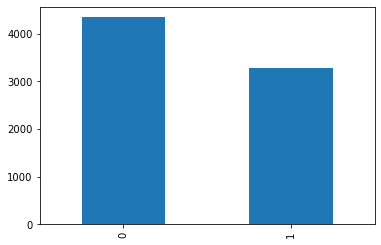

In [50]:
Y.value_counts().plot(kind='bar')

In [51]:
Y.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [52]:
#there is a slight class imbalance

In [53]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,17269,17270,17271,17272,17273,17274,17275,17276,17277,17278
0,0,1,221,4521,0.000,0.149,0.851,0.2732,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,4,221,4521,0.286,0.000,0.714,-0.3400,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,5,221,4521,0.095,0.000,0.905,-0.2960,2,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,6,221,4521,0.000,0.000,1.000,0.0000,3,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,7,221,4521,0.000,0.000,1.000,0.0000,4,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
pca = PCA(n_components=1000)

In [55]:
X = pca.fit_transform(X)
X

array([[ 8.26118136e+03, -5.39271777e+02, -1.57475262e+03, ...,
        -4.30904754e-03, -1.22987592e-02,  4.77844861e-03],
       [ 8.25806968e+03, -5.40075322e+02, -1.57472990e+03, ...,
        -8.14945209e-03, -5.10815122e-03, -3.61383081e-04],
       [ 8.25639141e+03, -5.40209626e+02, -1.57471609e+03, ...,
         2.29479658e-03,  6.25513503e-03,  2.68841419e-03],
       ...,
       [-7.15175775e+03,  2.25498993e+03, -1.42871502e+03, ...,
        -1.80096635e-02, -9.97939723e-03, -5.18072401e-03],
       [-7.15701954e+03,  2.25318253e+03, -1.42867895e+03, ...,
        -1.54102256e-03, -2.00230223e-03,  7.84783737e-03],
       [-7.15869781e+03,  2.25304822e+03, -1.42866514e+03, ...,
         1.57702456e-02,  2.33792501e-03, -2.20899897e-05]])

In [341]:
X.shape

(10876, 1000)

In [342]:
#scaling the data

In [343]:
mc = StandardScaler()
X = mc.fit_transform(X)
X

array([[ 1.97374239, -0.21170577, -1.07497893, ...,  0.61238067,
         0.72111773,  0.01450765],
       [ 1.97299895, -0.21202122, -1.07496343, ..., -1.77176377,
         1.38446069, -0.74997404],
       [ 1.97259798, -0.21207395, -1.074954  , ..., -0.59477416,
         2.88872228,  0.20864232],
       ...,
       [-1.70868146,  0.88525749, -0.97528877, ..., -0.36644301,
        -1.51078267, -1.34710441],
       [-1.70993859,  0.88454794, -0.97526415, ..., -0.13678581,
         0.06377507, -0.4644299 ],
       [-1.71033956,  0.88449522, -0.97525472, ...,  0.19616965,
         0.69799534, -0.55844494]])

In [344]:
#print(p)

In [384]:
X_train = X[0:6851:]
X_train.shape

(6851, 1000)

In [389]:
Y_train = Y[0:6851]
Y_train

0       1
1       1
2       1
3       1
4       1
       ..
6846    0
6847    1
6848    0
6849    0
6850    0
Name: target, Length: 6851, dtype: int64

In [390]:
Y_test = Y[6851:7613]
Y_test

6851    0
6852    1
6853    1
6854    1
6855    1
       ..
7608    1
7609    1
7610    1
7611    1
7612    1
Name: target, Length: 762, dtype: int64

In [385]:
len(Y_train)

7613

In [386]:
X_test = X[6851:10876:]
X_test.shape

(4025, 1000)

In [387]:
#oversampler = SMOTE(k_neighbors=4)
#X_train, Y = oversampler.fit_resample(X_train,Y)

In [392]:
Y_train.value_counts()

0    3935
1    2916
Name: target, dtype: int64

In [393]:
x_train,x_val,y_train,y_val = train_test_split(X_train,Y_train,train_size = 0.8,random_state= 42)

In [394]:
x_train.shape,x_val.shape,y_train.shape,y_val.shape

((5480, 1000), (1371, 1000), (5480,), (1371,))

In [395]:
y_val.value_counts()

0    782
1    589
Name: target, dtype: int64

In [396]:
Y

0       1
1       1
2       1
3       1
4       1
       ..
7608    1
7609    1
7610    1
7611    1
7612    1
Name: target, Length: 7613, dtype: int64

In [397]:
#data modeling

In [398]:
#Alg-1 SVM

In [399]:
smod = SVC()

In [401]:
smod.fit(X_train,Y_train)

SVC()

In [402]:
spred = smod.predict(x_val)
spred

array([0, 1, 0, ..., 0, 1, 0], dtype=int64)

In [403]:
pd.DataFrame(spred).value_counts()

0    836
1    535
dtype: int64

In [404]:
print(classification_report(smod.predict(x_val),y_val))

              precision    recall  f1-score   support

           0       0.99      0.92      0.95       836
           1       0.89      0.98      0.93       535

    accuracy                           0.95      1371
   macro avg       0.94      0.95      0.94      1371
weighted avg       0.95      0.95      0.95      1371



In [405]:
scores = cross_val_score(smod,x_val,y_val, cv=10)
scores 

array([0.68115942, 0.69343066, 0.72262774, 0.72262774, 0.69343066,
       0.70072993, 0.74452555, 0.67883212, 0.72262774, 0.73722628])

In [406]:
np.mean(scores)

0.7097217814450439

In [77]:
#Hyperparmeter tuning

In [78]:
param_grid = {'C': [0.1, 1, 10, 100, 1000],'gamma': [1, 0.1, 0.01, 0.001, 0.0001],'kernel': ['rbf']}

In [79]:
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)

In [80]:
#grid.fit(X_train,Y)

In [81]:
#print(grid.best_estimator_)

In [82]:
#print(grid.best_score_)

In [83]:
#print(p)

In [84]:
#LSTM
#LSTM IS preferred over conventional RNNs because of having a memory cell. SO basically if while traversing through longer texts it doesnt suffer form the vanishing gradient problem

In [85]:
#max_words = 1000
#max_len = 200

In [407]:
y = Y
y

0       1
1       1
2       1
3       1
4       1
       ..
7608    1
7609    1
7610    1
7611    1
7612    1
Name: target, Length: 7613, dtype: int64

In [408]:
#Using a tokenizer to convert the text data only into feature vectors and pass them through an LSTM Layer

max_fatures = 5000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(df_train['text'].values)
X = tokenizer.texts_to_sequences(df_train['text'].values)
X = pad_sequences(X)

In [409]:
X

array([[   0,    0,    0, ..., 4314,   81,   37],
       [   0,    0,    0, ...,  216,  734, 1341],
       [   0,    0,    0, ..., 1342,   19, 1055],
       ...,
       [   0,    0,    0, ...,    4,  588, 1532],
       [   0,    0,    0, ...,  121, 1960,  305],
       [   0,    0,    0, ...,  168,  702,   53]])

In [410]:
#one hot encoding
y = to_categorical(y)
y

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [411]:
X.shape, y.shape

((7613, 28), (7613, 2))

In [412]:
#Embedding is mapping memory indices to word vectors
embed_dim = 128
lstm_out = 196
model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 28, 128)           640000    
                                                                 
 spatial_dropout1d_2 (Spatia  (None, 28, 128)          0         
 lDropout1D)                                                     
                                                                 
 lstm_2 (LSTM)               (None, 196)               254800    
                                                                 
 dense_2 (Dense)             (None, 2)                 394       
                                                                 
Total params: 895,194
Trainable params: 895,194
Non-trainable params: 0
_________________________________________________________________
None


In [413]:
X_train,X_test,y_train,y_test = train_test_split(X[0:7613:],y,train_size=0.8)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(6090, 28) (1523, 28) (6090, 2) (1523, 2)


In [414]:
batch_size = 32
model.fit(X_train, y_train,validation_data = (X_test,y_test), epochs = 2, batch_size=batch_size, verbose = 1)

Epoch 1/2
191/191 [==============================] - 14s 65ms/step - loss: 0.5444 - accuracy: 0.7230 - val_loss: 0.4525 - val_accuracy: 0.8043
Epoch 2/2
191/191 [==============================] - 12s 64ms/step - loss: 0.3719 - accuracy: 0.8420 - val_loss: 0.4631 - val_accuracy: 0.8063


In [98]:
#Bert

In [106]:
X = df_train.text.to_list()
X

['our deeds are the reason of this earthquake may allah forgive us all',
 'forest fire near la ronge sask canada',
 'all residents asked to shelter in place are being notified by officers no other evacuation or shelter in place orders are expected',
 'people receive wildfires evacuation orders in california',
 'just got sent this photo from ruby alaska as smoke from wildfires pours into school',
 'rockyfire update california hwy closed in both directions due to lake county fire cafire wildfires',
 'flood disaster heavy rain causes flash flooding of streets in manitou colorado springs areas',
 'im on top of the hill and can see fire in the woods',
 'theres an emergency evacuation happening now in the building across the street',
 'im afraid that the tornado is coming to our area',
 'three people died from the heat wave so far',
 'haha south tampa is getting flooded hah wait second live in south tampa what am gonna do what am gonna do fvck flooding',
 'raining flooding florida tampabay t

In [107]:
y = Y
y

0       1
1       1
2       1
3       1
4       1
       ..
7608    1
7609    1
7610    1
7611    1
7612    1
Name: target, Length: 7613, dtype: int64

In [109]:
test_data = df_test.text.to_list()
test_data

['just happened terrible car crash',
 'heard about earthquake is different cities stay safe everyone',
 'there is forest fire at spot pond geese are fleeing across the street cannot save them all',
 'apocalypse lighting spokane wildfires',
 'typhoon soudelor kills in china and taiwan',
 'were shaking its an earthquake',
 'theyd probably still show more life than arsenal did yesterday eh eh',
 'hey how are you',
 'what nice hat',
 'fuck off',
 'no dont like cold',
 'nooooooooo dont do that',
 'no dont tell me that',
 'what if',
 'awesome',
 'birmingham wholesale market is ablaze bbc news fire breaks out at birminghams wholesale market',
 'will you wear shorts for race ablaze',
 'toke makinwa uªs marriage crisis sets nigerian twitter ablaze',
 'check these out nsfw',
 'psa uªm splitting my personalities techies follow burners follow',
 'beware world ablaze sierra leone amp guap',
 'burning man ablaze by turban diva via',
 'not diss song people will take thing and run with it smh its an e

In [105]:
bert_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
bert = TFBertModel.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [110]:
max_tweet_length = 2000

In [ ]:
#uses a tokenizer to create additional featuresand encodes every single token based on context. It returns data int eh form of tensors containing the toekn value and the respective attention

In [111]:
X = bert_tokenizer(
    text=X,
    add_special_tokens=True,
    max_length=max_tweet_length,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

In [112]:
X

{'input_ids': <tf.Tensor: shape=(7613, 41), dtype=int32, numpy=
array([[  101,  2256, 15616, ...,     0,     0,     0],
       [  101,  3224,  2543, ...,     0,     0,     0],
       [  101,  2035,  3901, ...,     0,     0,     0],
       ...,
       [  101, 11396,  2463, ...,     0,     0,     0],
       [  101,  2610, 11538, ...,     0,     0,     0],
       [  101,  1996,  6745, ...,     0,     0,     0]])>, 'attention_mask': <tf.Tensor: shape=(7613, 41), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])>}

In [113]:
test_data = bert_tokenizer(
    text=test_data,
    add_special_tokens=True,
    max_length=max_tweet_length,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

In [114]:
test_data

{'input_ids': <tf.Tensor: shape=(3263, 41), dtype=int32, numpy=
array([[  101,  2074,  3047, ...,     0,     0,     0],
       [  101,  2657,  2055, ...,     0,     0,     0],
       [  101,  2045,  2003, ...,     0,     0,     0],
       ...,
       [  101,  2665,  2240, ...,     0,     0,     0],
       [  101, 12669,  3314, ...,     0,     0,     0],
       [  101,  2103, 11253, ...,     0,     0,     0]])>, 'attention_mask': <tf.Tensor: shape=(3263, 41), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])>}

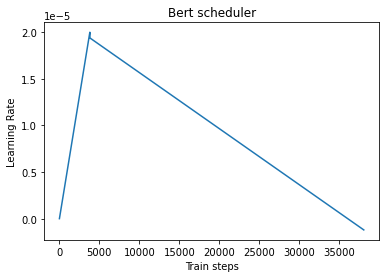

In [120]:
epochs = 5
steps_per_epoch = X['input_ids'].numpy().shape[0]
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

class BertLrSchedule(LearningRateSchedule):

    @tf.function
    def __init__(self, initial_learning_rate, num_warmups, num_train_steps):
        self.overshoot = 1000
        self.initial_learning_rate = initial_learning_rate
        self.num_warmups = num_warmups
        self.num_train_steps = num_train_steps
        self.angle_warm = self.initial_learning_rate / self.num_warmups
        self.angle_decay = - self.initial_learning_rate / \
            (self.num_train_steps - self.num_warmups - self.overshoot)
    
    @tf.function
    def __call__(self, step):
        if step <= self.num_warmups:
            return (tf.cast(step, tf.float32) + 1) * self.angle_warm
        else:
            return self.initial_learning_rate + (tf.cast(step, tf.float32) - self.num_warmups + 1 + self.overshoot) * self.angle_decay
        
        
schedule = BertLrSchedule(initial_learning_rate=2e-5, 
                          num_warmups=num_warmup_steps, 
                          num_train_steps=num_train_steps)

In [134]:
input_ids = Input(shape=(max_tweet_length,), dtype=tf.int32, name="input_ids")
input_ids

<KerasTensor: shape=(None, 2000) dtype=int32 (created by layer 'input_ids')>

In [154]:
max_tweet_length=41

In [140]:
def bert():
    input_ids = Input(shape=(max_tweet_length,), dtype=tf.int32, name="input_ids")
    input_mask = Input(shape=(max_tweet_length,), dtype=tf.int32, name="attention_mask")
    embeddings = bert(input_ids,attention_mask = input_mask)['pooler_output']
    net = tf.keras.layers.Dropout(0.1)(embeddings)
    net = tf.keras.layers.Dense(256, activation='relu', name='pre-clf')(net)
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(inputs=[input_ids, input_mask], outputs=net)

In [144]:
skf = StratifiedKFold(n_splits=10)
train_average_score = 0
validation_average_score = 0
validation_oof_predictions = np.zeros((len(X['input_ids'].numpy())))
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
optimizer = Adam(learning_rate=schedule)
epochs = 5
averaged_test_predictions = np.zeros((test_data['input_ids'].shape[0]))

In [145]:
for fold_n, (train_idx, test_idx) in enumerate(skf.split(X['input_ids'].numpy(), y)):
    X_train_ids = X['input_ids'].numpy()[train_idx]
    X_train_att = X['attention_mask'].numpy()[train_idx]
    y_train = y[train_idx]
    
    X_test_ids = X['input_ids'].numpy()[test_idx]
    X_test_att = X['attention_mask'].numpy()[test_idx]
    y_test = y[test_idx]
    model = bert()
    model.layers[2].trainable = True
    
    model.compile(optimizer=optimizer,
                  loss=loss)
    
    model.fit(x={'input_ids':X_train_ids,'attention_mask':X_train_att}, 
              y=y_train, batch_size=32, epochs=epochs)
    
    train_predictions = model.predict({'input_ids':X_train_ids,'attention_mask':X_train_att})
    validation_predictions = model.predict({'input_ids':X_test_ids,'attention_mask':X_test_att})
    
    train_score = roc_auc_score(y_train, train_predictions)
    validation_score = roc_auc_score(y_test, validation_predictions)
    
    train_average_score += train_score / 5
    validation_average_score += validation_score / 5
    validation_oof_predictions[test_idx,] = (validation_predictions > 0.5).astype(int).flatten()
    print(f'Fold: {fold_n}, train auc: {train_score:.3f}, validation auc: {validation_score:.3f}')
    
    test_predictions = model.predict({'input_ids':test_data['input_ids'],
                                      'attention_mask':test_data['attention_mask']}).flatten()
    averaged_test_predictions += test_predictions / 5

119/119 [==============================] - 403s 3s/step - loss: 0.8535
Fold: 0, train auc: 0.954, validation auc: 0.903
119/119 [==============================] - 415s 3s/step - loss: 0.6153
Fold: 1, train auc: 0.915, validation auc: 0.954


In [146]:
print(f'Train average: {train_average_score:.3f}, validation average: {validation_average_score:.3f}')
print(f'OOF Accuracy Score: {accuracy_score(y, validation_oof_predictions)}')

Train average: 0.374, validation average: 0.371
OOF Accuracy Score: 0.8845396033101274


In [ ]:
#Alg-2 Xgboost

In [360]:
y_train.shape

(6090,)

In [361]:
xmod = XGBClassifier()
xmod.fit(x_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [362]:
print(classification_report(xmod.predict(x_val),y_val))

              precision    recall  f1-score   support

           0       0.85      0.77      0.81       967
           1       0.65      0.76      0.70       556

    accuracy                           0.77      1523
   macro avg       0.75      0.76      0.75      1523
weighted avg       0.78      0.77      0.77      1523



In [363]:
scores = cross_val_score(xmod, x_train, y_train, cv=10)
scores

array([0.77011494, 0.76026273, 0.73234811, 0.77668309, 0.79146141,
       0.74055829, 0.76190476, 0.75369458, 0.75862069, 0.77339901])

In [364]:
np.mean(scores)

0.7619047619047619

In [365]:
#ALg-3 Logistic regression

In [366]:
lmod = LogisticRegression()
lmod.fit(x_train,y_train)

C:\Users\abhis\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [367]:
print(classification_report(lmod.predict(x_val),y_val))

              precision    recall  f1-score   support

           0       0.82      0.80      0.81       901
           1       0.72      0.75      0.73       622

    accuracy                           0.78      1523
   macro avg       0.77      0.77      0.77      1523
weighted avg       0.78      0.78      0.78      1523



In [368]:
scores = cross_val_score(xmod, x_train, y_train, cv=10)
np.mean(scores)

0.7619047619047619

In [369]:
#Alg-4 Random Fprest

In [370]:
rmod = RandomForestClassifier()
rmod = rmod.fit(x_train,y_train)

In [371]:
print(classification_report(rmod.predict(x_val),y_val))

              precision    recall  f1-score   support

           0       0.92      0.71      0.80      1130
           1       0.50      0.83      0.62       393

    accuracy                           0.74      1523
   macro avg       0.71      0.77      0.71      1523
weighted avg       0.81      0.74      0.76      1523



In [372]:
scores = cross_val_score(rmod, x_train, y_train, cv=10)
np.mean(scores)

0.729392446633826